This is a comparison experiment in which only the student model is used to test the performance of the VGG11 network.

In [1]:
import torch
import torchvision
from torchvision import datasets
import torch.optim as optim
import torch.nn.functional
import torchvision.transforms as transforms
from torch import nn

import matplotlib.pyplot as plt
import numpy as np

/home/xiaohan/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                        (0.2023, 0.1994, 0.2010)),
])

In [3]:
training_data = datasets.CIFAR10(
    root="~/data",
    train=True,
    download=False,
    transform=transform_train
)
test_data = datasets.CIFAR10(
    root="~/data",
    train=False,
    download=False,
    transform=transform_test
)

In [4]:
# parameters
max_epoch = 50
batch_size = 256
lr = 1e-3

use_cuda = torch.cuda.is_available()

In [5]:


trainloader = torch.utils.data.DataLoader(training_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=8)
testloader = torch.utils.data.DataLoader(test_data,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=8)

In [6]:
model = torchvision.models.resnet18()

In [7]:
loss_func = nn.CrossEntropyLoss()

In [8]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,
                      weight_decay=5e-4)

In [9]:
if use_cuda:
    model.cuda()

In [10]:
def counter(outputs, labels):
    pre = torch.max(outputs.data.cpu(), 1)[1].numpy()
    y = labels.data.cpu().numpy()
    correct_num = (pre == y).sum()
    return correct_num

In [11]:
summary = {"train_acc": [], "val_acc": []}
for epoch in range(max_epoch):

    model.train()

    correct_num = 0
    total_num = 0
    for i, (train_batch, labels_batch) in enumerate(trainloader):
        if use_cuda:
            train_batch, labels_batch = train_batch.cuda(), labels_batch.cuda()
        
        # train
        outputs_batch = model(train_batch)

        loss = loss_func(outputs_batch, labels_batch)

        # clear previous gradients, compute gradients of all variables wrt loss
        optimizer.zero_grad()
        loss.backward()

        # performs updates using calculated gradients
        optimizer.step()
        correct_num_batch = counter(outputs_batch, labels_batch)
        correct_num += correct_num_batch
        total_num += len(labels_batch)
    
    # traing accuracy and loss
    train_acc = correct_num / total_num * 100.
    summary["train_acc"].append(train_acc)


    # evaluation
    correct_num = 0
    total_num = 0
    model.eval()
    for i, (val_batch, labels_val_batch) in enumerate(testloader):
        if use_cuda:
            val_batch, labels_val_batch = val_batch.cuda(), labels_val_batch.cuda()
        
        outputs_val_batch = model(val_batch)
        correct_num_batch = counter(outputs_val_batch, labels_val_batch)
        correct_num += correct_num_batch
        total_num += len(labels_val_batch)
    val_acc = correct_num / total_num * 100.
    summary["val_acc"].append(val_acc)

    print("Epoch: {}/{}, training acc: {:>6.2f}, val acc: {:>6.2f}".format(epoch+1, max_epoch, train_acc, val_acc))
            

Epoch: 1/50, training acc:  33.68, val acc:  44.31
Epoch: 2/50, training acc:  49.26, val acc:  49.06
Epoch: 3/50, training acc:  55.90, val acc:  52.95
Epoch: 4/50, training acc:  61.40, val acc:  55.33
Epoch: 5/50, training acc:  66.64, val acc:  56.83
Epoch: 6/50, training acc:  71.85, val acc:  57.20
Epoch: 7/50, training acc:  76.92, val acc:  57.44
Epoch: 8/50, training acc:  82.35, val acc:  57.13
Epoch: 9/50, training acc:  87.27, val acc:  57.88
Epoch: 10/50, training acc:  91.79, val acc:  58.25
Epoch: 11/50, training acc:  95.34, val acc:  58.00
Epoch: 12/50, training acc:  97.76, val acc:  58.05
Epoch: 13/50, training acc:  98.97, val acc:  57.99
Epoch: 14/50, training acc:  99.54, val acc:  58.67
Epoch: 15/50, training acc:  99.74, val acc:  58.56
Epoch: 16/50, training acc:  99.89, val acc:  58.48
Epoch: 17/50, training acc:  99.94, val acc:  58.66
Epoch: 18/50, training acc:  99.96, val acc:  58.69
Epoch: 19/50, training acc:  99.98, val acc:  58.73
Epoch: 20/50, trainin

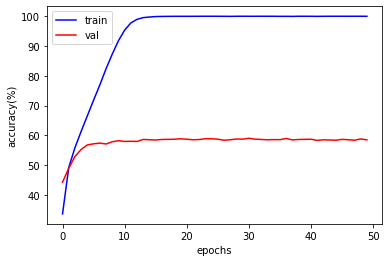

In [13]:
plt.plot(summary["train_acc"], color='b', label = "train")
plt.plot(summary["val_acc"], color='r', label = "val")
plt.xlabel("epochs")
plt.ylabel("accuracy(%)")
plt.legend()
plt.show()